<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Kusal/LSTM_speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.layers import ConvLSTM2D
import seaborn as sns

In [234]:
df = pd.read_csv('https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/August-2021%20Mannar%20Wind%20Data1.csv')
df = df.rename(columns = {'TimeStamp': 'Date & Time', 'Average  Wind Speed(m/s)': 'Wind Speed (m/s)', 'Average  Wind Dirction(deg)':'Wind Direction(deg)','Average Active Power(MW)':'Active Power(MW)'}, inplace = False)
df=df[['Date & Time','Wind Speed (m/s)','Wind Direction(deg)','Active Power(MW)']]
df['Date & Time'] = pd.to_datetime(df['Date & Time'], format="%m/%d/%Y %H:%M")
df["Active Power(MW)"] = pd.to_numeric(df["Active Power(MW)"])
#df.set_index('Date & Time',inplace=True)
df_n=df.head(4389)
train_dates=df_n['Date & Time']#separate dates for future plotting
cols=list(df_n)[1:4]
df_for_training= df_n[cols].astype(float)

#print(cols)

In [235]:
df_for_training.describe()

,Wind Speed (m/s),Wind Direction(deg),Active Power(MW)
count,4389.000000,4389.000000,4389.000000
mean,9.946715,197.393964,72.479483
std,2.590403,14.234304,31.081689
min,1.810000,130.840000,-0.760000
25%,8.200000,188.990000,48.320000
50%,10.040000,194.780000,84.330000
75%,11.870000,203.660000,100.990000
max,16.450000,311.140000,103.420000


In [236]:
train_dates.tail(100)

4289   2021-08-31 04:10:00
4290   2021-08-31 04:20:00
4291   2021-08-31 04:30:00
4292   2021-08-31 04:40:00
4293   2021-08-31 04:50:00
               ...        
4384   2021-08-31 20:00:00
4385   2021-08-31 20:10:00
4386   2021-08-31 20:20:00
4387   2021-08-31 20:30:00
4388   2021-08-31 20:40:00
Name: Date & Time, Length: 100, dtype: datetime64[ns]

In [237]:
# df_for_plot=df_for_training.tail(2000)
# df_for_plot.plot.line()
scaler= StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [238]:
trainX=[]
trainY=[]

n_future=1
n_past=14

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [239]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [240]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (4375, 14, 3).
trainY shape == (4375, 1).


In [241]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 14, 64)            17408     
_________________________________________________________________
lstm_19 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [242]:
history = model.fit(trainX, trainY, epochs=10, batch_size=10, validation_split=0.05, verbose=1)

Epoch 1/10
416/416 [==============================] - 8s 15ms/step - loss: 0.1442 - val_loss: 0.0369
Epoch 2/10
416/416 [==============================] - 6s 14ms/step - loss: 0.0695 - val_loss: 0.0245
Epoch 3/10
416/416 [==============================] - 6s 15ms/step - loss: 0.0620 - val_loss: 0.0194
Epoch 4/10
416/416 [==============================] - 6s 14ms/step - loss: 0.0546 - val_loss: 0.0169
Epoch 5/10
416/416 [==============================] - 6s 14ms/step - loss: 0.0498 - val_loss: 0.0128
Epoch 6/10
416/416 [==============================] - 6s 14ms/step - loss: 0.0452 - val_loss: 0.0126
Epoch 7/10
416/416 [==============================] - 6s 14ms/step - loss: 0.0423 - val_loss: 0.0089
Epoch 8/10
416/416 [==============================] - 6s 14ms/step - loss: 0.0451 - val_loss: 0.0102
Epoch 9/10
416/416 [==============================] - 6s 14ms/step - loss: 0.0408 - val_loss: 0.0098
Epoch 10/10
416/416 [==============================] - 6s 14ms/step - loss: 0.0388 - val_lo

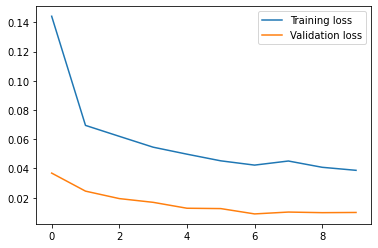

In [243]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [244]:
n_future=20
forecast_period_dates=pd.date_range(list(train_dates)[-1],periods=n_future,freq='10min')
forecast_period_dates

DatetimeIndex(['2021-08-31 20:40:00', '2021-08-31 20:50:00',
               '2021-08-31 21:00:00', '2021-08-31 21:10:00',
               '2021-08-31 21:20:00', '2021-08-31 21:30:00',
               '2021-08-31 21:40:00', '2021-08-31 21:50:00',
               '2021-08-31 22:00:00', '2021-08-31 22:10:00',
               '2021-08-31 22:20:00', '2021-08-31 22:30:00',
               '2021-08-31 22:40:00', '2021-08-31 22:50:00',
               '2021-08-31 23:00:00', '2021-08-31 23:10:00',
               '2021-08-31 23:20:00', '2021-08-31 23:30:00',
               '2021-08-31 23:40:00', '2021-08-31 23:50:00'],
              dtype='datetime64[ns]', freq='10T')

In [245]:
forecast=model.predict(trainX[-n_future:])

In [246]:
forecast_copies =np.repeat(forecast,df_for_training.shape[1],axis=-1)
y_pred_future=scaler.inverse_transform(forecast_copies)[:,0]

In [247]:
y_pred_future

array([11.420384 , 11.449408 , 11.751787 , 11.896649 , 11.937428 ,
       12.14164  , 12.173885 , 12.106152 , 12.208905 , 11.875417 ,
       12.067813 , 12.173839 , 12.388228 , 12.34842  , 12.308717 ,
       12.3230915, 12.295853 , 12.262947 , 11.929059 , 11.567719 ],
      dtype=float32)

In [248]:
forecast_dates=[]
for time_i in forecast_period_dates:
  forecast_dates.append(time_i.date())

In [249]:
df_forecast=pd.DataFrame({'Date & Time':np.array(forecast_period_dates),'Wind Speed (m/s)':y_pred_future})
df_forecast['Date & Time']=pd.to_datetime(df_forecast['Date & Time'])

In [250]:
df_forecast.head(20)

,Date & Time,Wind Speed (m/s)
0,2021-08-31 20:40:00,11.420384
1,2021-08-31 20:50:00,11.449408
2,2021-08-31 21:00:00,11.751787
3,2021-08-31 21:10:00,11.896649
4,2021-08-31 21:20:00,11.937428
5,2021-08-31 21:30:00,12.141640
6,2021-08-31 21:40:00,12.173885
7,2021-08-31 21:50:00,12.106152
8,2021-08-31 22:00:00,12.208905
9,2021-08-31 22:10:00,11.875417


In [251]:
df.tail(20)

,Date & Time,Wind Speed (m/s),Wind Direction(deg),Active Power(MW)
4389,2021-08-31 20:50:00,10.85,190.73,96.60
4390,2021-08-31 21:00:00,10.64,190.91,94.72
4391,2021-08-31 21:10:00,10.84,188.53,96.15
4392,2021-08-31 21:20:00,11.41,186.94,100.32
4393,2021-08-31 21:30:00,12.05,190.72,101.28
4394,2021-08-31 21:40:00,11.90,193.26,100.94
4395,2021-08-31 21:50:00,11.98,192.80,101.13
4396,2021-08-31 22:00:00,12.11,191.88,101.33
4397,2021-08-31 22:10:00,12.31,191.40,101.48
4398,2021-08-31 22:20:00,12.27,191.65,101.49


In [252]:
original=df[['Date & Time','Wind Speed (m/s)']]
original['Date & Time']=pd.to_datetime(original['Date & Time'])
original=original.loc[original['Date & Time'] >= '2021-08-31 07:30:00']
            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


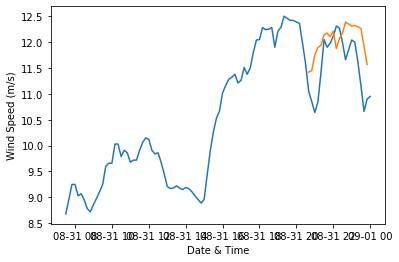

In [253]:
sns.lineplot(original['Date & Time'],original['Wind Speed (m/s)'])
sns.lineplot(df_forecast['Date & Time'],df_forecast['Wind Speed (m/s)'])